# Genetic analysis

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [2]:
from codes.docs.analysis.gene_analysis import genetic_file_preprocess, genetic_steps
from codes.docs.analysis import visualisation

In [3]:
dataset_path = "../../dataset"
preprocessed_dataset_path = "./preprocessed_dataset"

# Preprocessing for PRSice

In [4]:
def create_PRSice_preprocess_files(input_file_path: str,
                                   phenotypes:str,
                                   covariates:str,
                                   cohort: str=None,
                                   output_file_path: str = None):
    new_df = pd.read_csv(input_file_path)
    if isinstance(phenotypes,str):
        phenotypes = [phenotypes]
    phenotype_df = new_df[[
        'ID', 'ID']+phenotypes]
    phenotype_df.columns = [
        'FID', 'IID'
    ]+phenotypes
    if isinstance(covariates,str):
        covariates = [covariates]
    covariate_df = new_df[
        ['ID', 'ID'] + covariates]
    covariate_df.columns = [
        'FID', 'IID'
    ]+covariates
    if output_file_path is not None:
        phenotype_df.to_csv(output_file_path+'phenotype_'+cohort+'.txt',header=True,index=False,sep=" ")
        covariate_df.to_csv(output_file_path+'covariate_'+cohort+'.txt',header=True,index=False,sep=" ")
    return new_df,phenotype_df,covariate_df

In [24]:
_, _, _ = create_PRSice_preprocess_files(
    './preprocessed_data/volumetric/term/full_cohort_volumetric_term_dataset_withImperial.csv',
    cohort='full_cohort',
    ancestry=['full_Anc_PC' + str(i) for i in range(1, 10)],
    output_file_path='./dataset/Harriet_genetic_file',
    output=True)

In [21]:
ancestry = ['euro_Anc_PC'+str(i) for i in range(1,4)]
_,pheno,covar = create_PRSice_preprocess_files('./preprocessed_dataset/genetic_data/eur/european_data_with_PCA.csv',
                              phenotypes=['Brain_PC4'],
                              covariates=['GA_vol','PMA_vol','Gender','17 ICV (all except bone)']+ancestry,
                                               cohort = 'EUR',
                                output_file_path='../../dataset/genetic_dataset/pheno_cov_files/asd/')

In [12]:
_,_,_ = create_PRSice_preprocess_files(f'{preprocessed_dataset_path}/imaging_data/volumetric/term/european_volumetric_df.csv',
                                      cohort = 'Euro',
                                      ancestry=['euro_Anc_PC'+str(i) for i in range(1,4)],
                                      output_file_path = f'{dataset_path}/genetic_dataset',output=True)

# Result

Performing PRSice across multiple P-value threshold. The result is saved in the output.perm.prsice table.

In [4]:
model_fit_table_European = pd.read_table(
    'preprocessed_dataset/genetic_data/eur/Brain_PC4/output.perm.prsice'
)
# model_fit_table_Mixed = pd.read_table('./genetic_analysis/Harriet_genetic_file/all_PRS_Mixed/output.perm.prsice')
# model_fit_table_Full = pd.read_table('./genetic_analysis/Harriet_genetic_file/all_PRS_Full_cohort/output.perm.prsice')

## Plotting

In [6]:
def plot_PRSice_Barplot(model_fit_table:pd.DataFrame,
                        thresholds_to_plot:list=None,
                        phenotype='Frontal_lobe_WM'):
    """
    Ploting the PRSice results
    Args:
        model_fit_table: the output.perm.prsice file
        thresholds = the bar levels thresholds to plot
        phenotype = the phenotype to consider.
    Returns:
        a bar plot
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    sns.set(style='whitegrid', color_codes=True)
    data_full = model_fit_table[model_fit_table['Pheno'] ==
                                phenotype].reset_index(drop=True)
    data_full['neg_log10P'] = -np.log10(data_full['P'])
    #also plot the best threshold
    best_threshold = data_full.loc[data_full['R2'] == data_full['R2'].max(),
                                   'Threshold'].tolist()

    #make sure that the defined bar levels are present in the model_fit_table. If the threshold was not calculated, just pick the nearest one
    def find_nearest_value(value, array):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    thresholds = [
        threshold if threshold in data_full['Threshold'].values else
        find_nearest_value(threshold, data_full['Threshold'].values)
        for threshold in thresholds
    ]

    thresholds = thresholds + best_threshold
    thresholds = sorted(set(thresholds))
    data = data_full[[
        True if threshold in thresholds else False
        for threshold in data_full['Threshold']
    ]].reset_index(drop=True)
    p_values = data['neg_log10P'].values
    pal = sns.color_palette("coolwarm", len(p_values))
    rank = p_values.argsort().argsort()
    my_cmap = ListedColormap(pal)
    norm = plt.Normalize(p_values.min(), p_values.max())
    sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
    sm.set_array([])
    g = sns.barplot(x='Threshold',
                    y='R2',
                    data=data,
                    palette=np.array(pal)[rank],
                    ax=ax[0])
    cbar = g.figure.colorbar(sm, ax=ax[0])
    for index, row in data.iterrows():
        g.text(row.name, row.R2, round(row.P, 4), color='black', ha="center")
    ax[0].set_title('%s Barplot' % (phenotype))
    ax[0].set_xlabel('P-value threshold(Pt)')
    ax[0].set_ylabel('PRS model fit: R-squared')
    cbar.set_label('-Log 10 P-value')
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')

    ax[1].plot(data_full['Threshold'],
               data_full['neg_log10P'],
               'ko',
               markersize=.2)
    ax[1].plot(data['Threshold'], data['neg_log10P'], 'r-')
    ax[1].set_xlabel('P-value threshold(Pt)')
    ax[1].set_ylabel('PRS model fit: -log 10 P-value')
    return g.get_figure()


def plot_multiple_PRSice_Barplot(model_fit_table,
                                 thresholds=None,
                                 phenotypes=None,
                                 plot_individual=True):
    if plot_individual and len(phenotypes) > 1:
        for phenotype in phenotypes:
            plot_PRSice_Barplot(model_fit_table=model_fit_table,
                                thresholds=thresholds,
                                phenotype=phenotype)
    if len(phenotypes) > 1:
        sns.set(style='whitegrid', color_codes=True)
        fig, ax = plt.subplots(figsize=(8, 6))
        data = model_fit_table[[
            True if i in phenotypes else False
            for i in model_fit_table['Pheno']
        ]]
        def find_nearest_value(value, array):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return array[idx]

        new_thresholds = [
            threshold if threshold in model_fit_table['Threshold'].values else
            find_nearest_value(threshold, model_fit_table['Threshold'].values)
            for threshold in thresholds
        ]
        data = data[[
            True if threshold in new_thresholds else False
            for threshold in data['Threshold']
        ]].reset_index(drop=True)
        g = sns.barplot(x='Threshold', y='R2', data=data, hue='Pheno', ax=ax)
        plt.xlabel('P-value threshold(Pt)')
        plt.ylabel('PRS model fit: R-squared')
        plt.xticks(rotation=45)
        ax.set_xticklabels(thresholds)
        plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
        return g.get_figure()
    else:
        plot_PRSice_Barplot(model_fit_table=model_fit_table,
                            thresholds=thresholds,
                            phenotype=phenotypes[0])
        

In [8]:
model_fit_table_European

,Pheno,Set,Threshold,R2,P,Coefficient,Standard.Error,Num_SNP
0,-,Base,0.00010,0.021831,0.023175,107.963,47.1784,185
1,-,Base,0.00011,0.024515,0.016030,115.064,47.3674,195
2,-,Base,0.00012,0.021123,0.025554,111.027,49.3452,207
3,-,Base,0.00013,0.017457,0.042616,107.606,52.7302,221
4,-,Base,0.00014,0.016701,0.047416,106.834,53.5495,230
...,...,...,...,...,...,...,...,...
13229,-,Base,0.49970,0.037620,0.002732,5930.010,1954.0200,85040
13230,-,Base,0.49980,0.037645,0.002723,5933.410,1954.4800,85049
13231,-,Base,0.49990,0.037551,0.002757,5926.310,1954.6900,85057
13232,-,Base,0.50000,0.037444,0.002797,5918.490,1955.0300,85074


ValueError: attempt to get argmin of an empty sequence

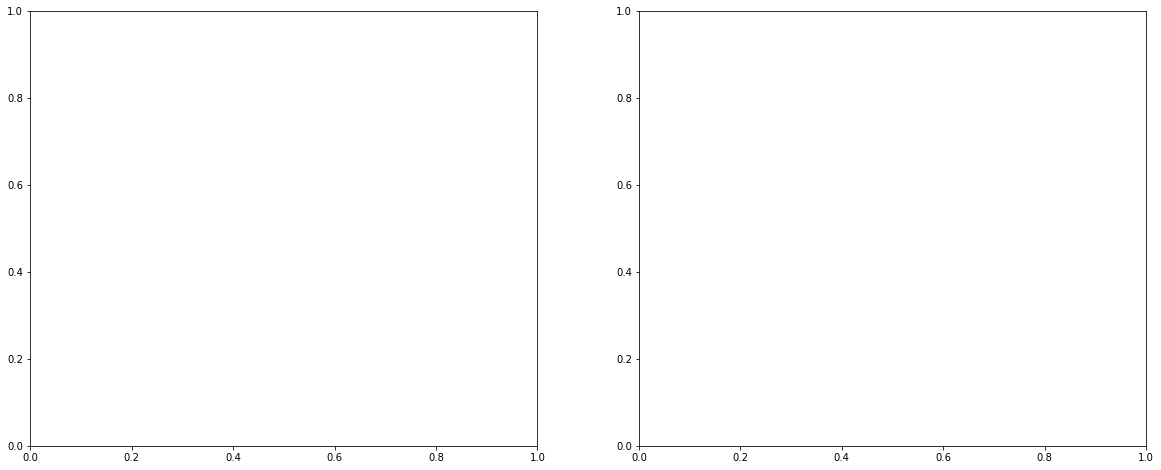

In [9]:
plot_multiple_PRSice_Barplot(
    model_fit_table_European,
    thresholds=model_fit_table_European.Threshold.values,
    phenotypes=['Brain_PC4'],
    plot_individual=True)

In [29]:
thresholds = [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1]
phenotypes = ['Frontal_lobe_WM','STG_WM','STG_GM','WM_sum']

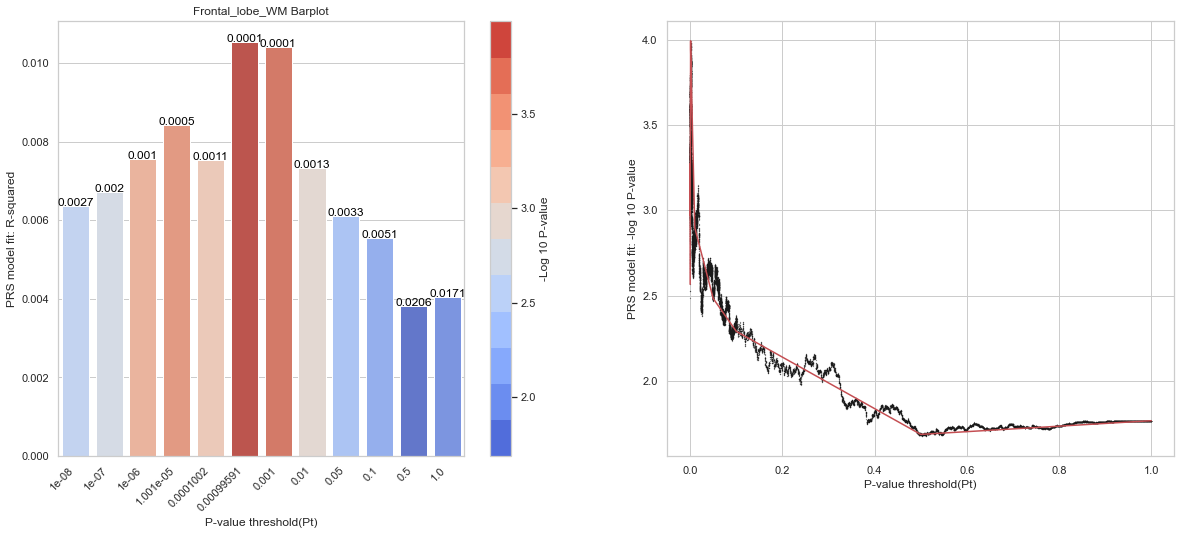

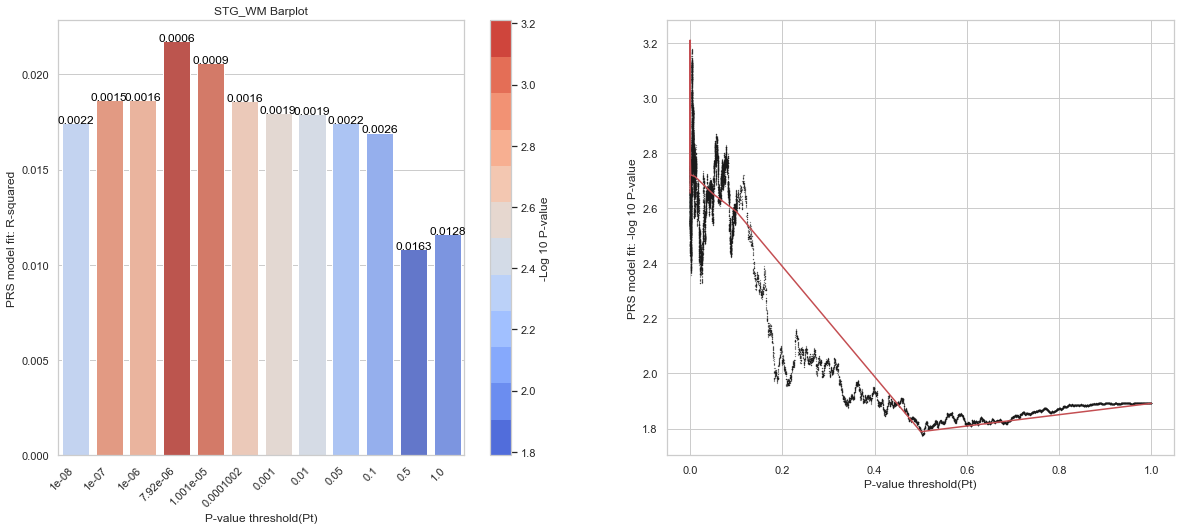

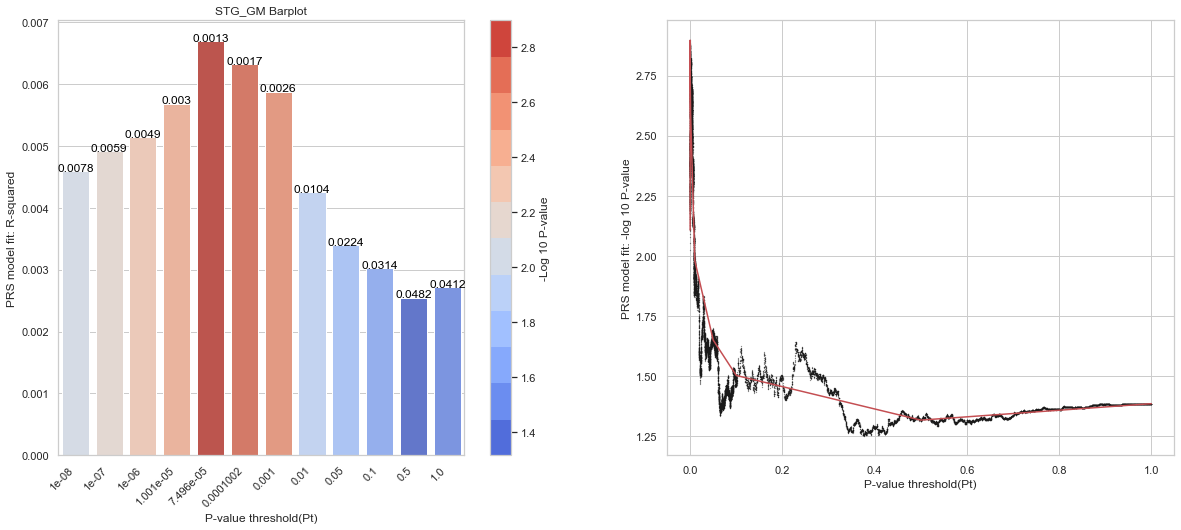

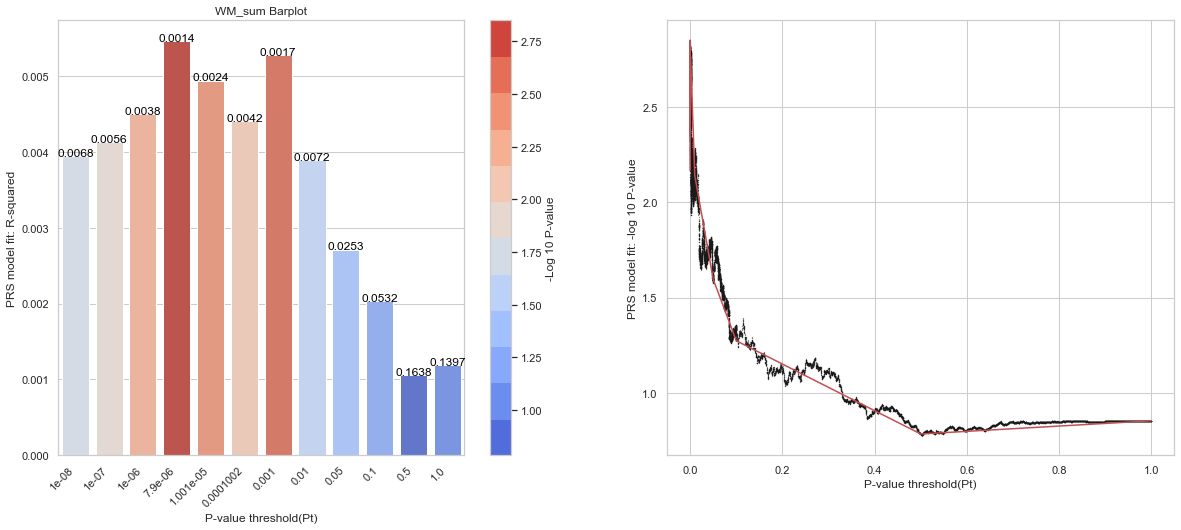

In [211]:
for phenotype in phenotypes:
    fig = plot_PRSice_Barplot(model_fit_table_Mixed,thresholds=thresholds,phenotype = phenotype)
    fig.savefig('./genetic_analysis/Harriet_genetic_file/all_PRS_Mixed/%s_Barplot.png'%phenotype,dpi=300)

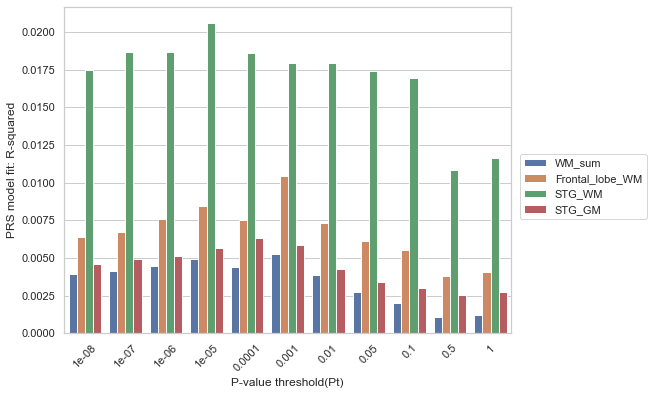

In [223]:
fig = plot_multiple_PRSice_Barplot(model_fit_table_Mixed,thresholds=thresholds,phenotypes=phenotypes,plot_individual=False)
fig.savefig('./genetic_analysis/Harriet_genetic_file/all_PRS_Mixed/combined_Barplot.png',dpi=300,bbox_inches='tight')

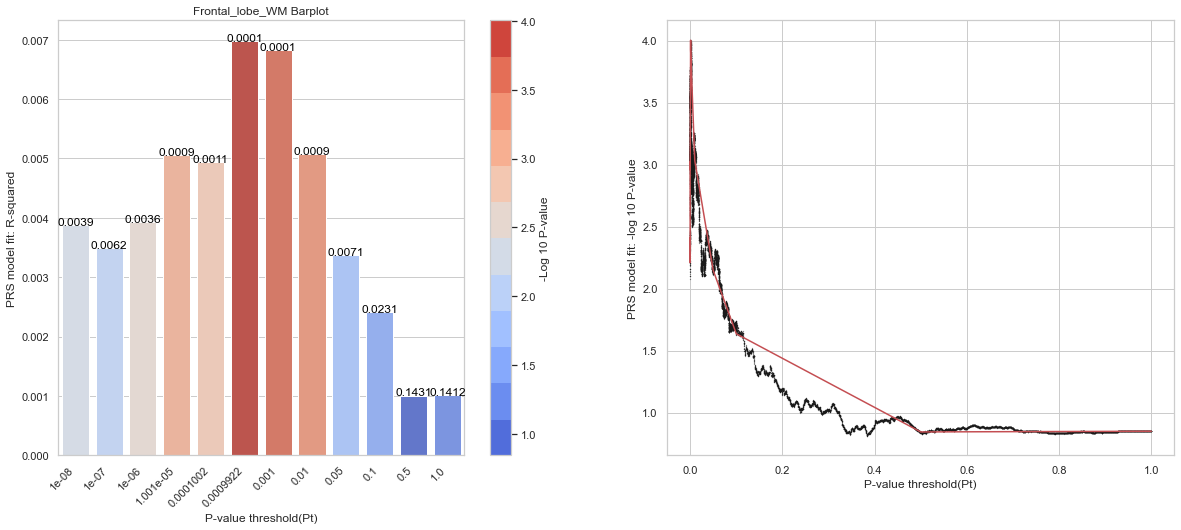

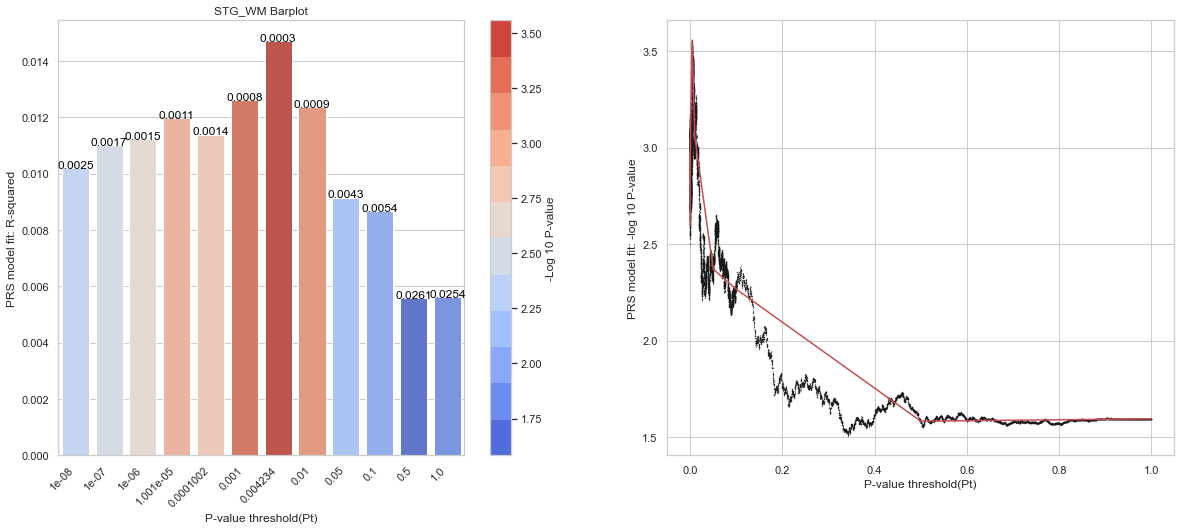

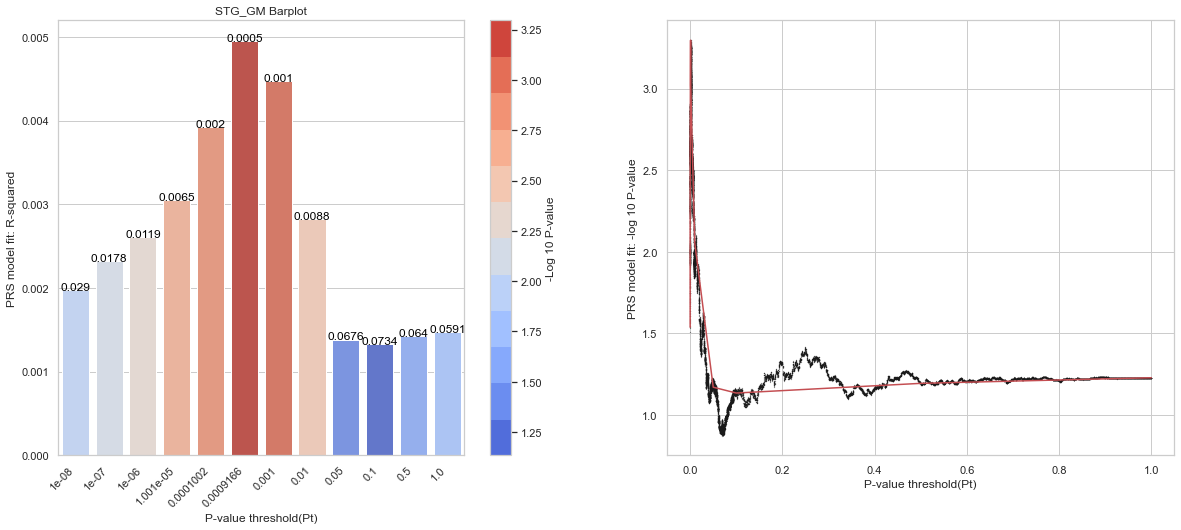

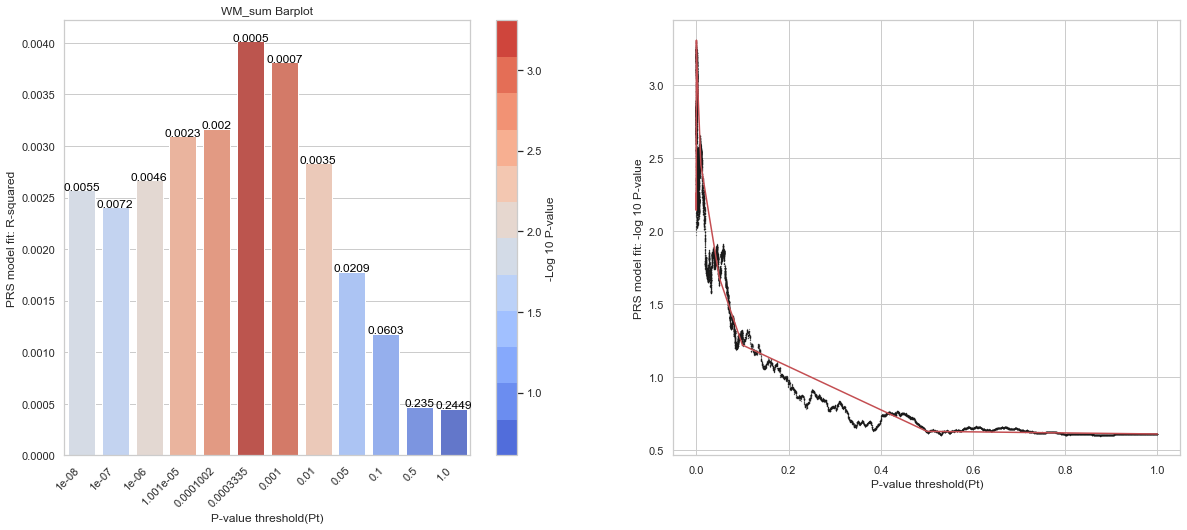

In [35]:
for phenotype in phenotypes:
    fig = plot_PRSice_Barplot(model_fit_table_Full,thresholds=thresholds,phenotype = phenotype)
    fig.savefig('./genetic_analysis/Harriet_genetic_file/all_PRS_Full_cohort/%s_Barplot.png'%phenotype,dpi=300)

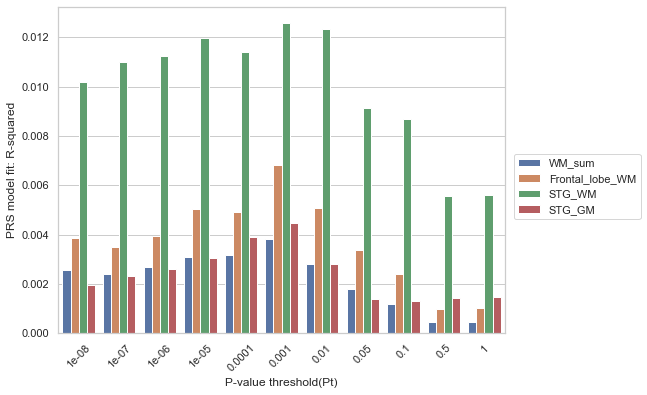

In [36]:
fig = plot_multiple_PRSice_Barplot(model_fit_table_Full,thresholds=thresholds,phenotypes=phenotypes,plot_individual=False)
fig.savefig('./dataset/Harriet_genetic_file/all_PRS_Full_cohort/combined_Barplot.png',dpi=300,bbox_inches='tight')

## Generate the best SNPs and Gene ID list

This process is performed by PRSice- essentially, PRS are generated at different thresholds. Then a linear regression test, $phenotype = PRS + covariate$, is calculate.

From here, a PRS threshold is chosen such that at that threshold the phenotype is most explained (by R2 fit). And all the SNPs making up that PRS are chosen.

In [4]:
variable = 'Brain_PC4'
cohort = 'eur'
snp_file = pd.read_table(
    f'preprocessed_dataset/genetic_data/{cohort}/{variable}/output.perm.snp'
)

In [9]:
best_SNPs_threshold = 0.019220
best_SNPs = genetic_steps.SNPsFunctionalAnalysis.get_the_best_SNPs(snp_file,threshold=best_SNPs_threshold)

In [8]:
best_SNPs

,CHR,SNP,BP,P,Base
0,20,20:21248116,21248116,2.041000e-09,1
1,8,8:10583506,10583506,4.404000e-08,1
2,1,1:96978961,96978961,1.135000e-07,1
3,20,20:21531772,21531772,1.210000e-07,1
4,3,3:62481063,62481063,2.069000e-07,1
...,...,...,...,...,...
8580,6,6:26175852,26175852,1.921000e-02,1
8581,1,1:168687822,168687822,1.922000e-02,1
8582,2,2:204304214,204304214,1.922000e-02,1
8583,11,11:116465680,116465680,1.922000e-02,1


From here following steps are done to perform functional analysis of the selected SNPs.

1. Calculate linear association between each of the SNP with the phenotype of interest (If using PLINK, new bed files must be created)

    * $Phenotype = A1_{SNP count} + covariates$ where A1 is the effect allele

2. The SNPs most associated with the phenotype were selected. These are Schizophrenia SNPs mostly associated with the phenotype.
    * Threshold set at 0.05

3. Perform gene anotation to the new set of SNPs (Must be done with the Human genome build 37, or hg19, downloadable from Magma website, and can be used with Magma)


In [6]:
best_SNPs_annot = genetic_steps.SNPsFunctionalAnalysis(snps_list=best_SNPs.SNP.to_list(),
                                                      bed_file=f'{dataset_path}/genetic_dataset/target_files/lifted37_dHCP_merged_cleaned_EUROPEANS.bed')

The object of class `SNPsFunctionalAnalysis` will perform all the described 3 steps, and requires the SNPs list, pheno-covar files, bed files, gene_build file.

Given the large bed file, it might take a while to run the mass univariate, as it will need to first read the file, and then do extraction of the snps of interest.

First, it will look at the phenotype and covariate files, extract the correct 

In [7]:
cohort = 'EUR'
_, best_SNPs_annot.snp_association = best_SNPs_annot.do_mass_univariate_test(
    orig_bed_file=best_SNPs_annot.orig_bed_file,
    snps_list=best_SNPs_annot.snps_list,
    pheno_file=
    f'{dataset_path}/genetic_dataset/pheno_cov_files/asd/phenotype_{cohort}.txt',
    covar_file=
    f'{dataset_path}/genetic_dataset/pheno_cov_files/asd/covariate_{cohort}.txt',
    phenotype=variable)

100%|██████████████████████████████████████| 8585/8585 [00:48<00:00, 175.71it/s]


In [13]:
best_SNPs_annot.snp_association

,SNP,A1,BETA,STAT,P
0,1:2723345,T,-0.007369,-0.058188,0.953658
1,1:3230477,C,0.157358,1.097805,0.273636
2,1:3261682,C,0.286144,2.339145,0.020335
3,1:4192490,T,0.311459,2.502599,0.013150
4,1:4380344,C,0.223713,1.834709,0.068065
...,...,...,...,...,...
8580,22:49635619,G,-0.284814,-1.331189,0.184673
8581,22:49968720,G,0.031921,0.213388,0.831246
8582,22:50120350,A,0.060997,0.422089,0.673422
8583,22:50529850,C,0.004683,0.031611,0.974814


In [28]:
# save the bed_file
import bed_reader
bed_reader.to_bed(f'./preprocessed_dataset/genetic_data/{cohort}/{variable}/updated_{cohort}_with_ASD_PRS_Pt_{variable}_{best_SNPs_threshold}.bed',
                  updated_bed_file.genotype,
                  properties=updated_bed_file.properties_dict)

In [14]:
SNPs_linear_assoc = best_SNPs_annot.snp_association.copy()
SNPs_linear_assoc = SNPs_linear_assoc.merge(best_SNPs,on='SNP',suffixes=[f'_{variable}','_ASD'])

best_SNPs_annot.snp_association = SNPs_linear_assoc

In [15]:
best_SNPs_annot.snps_list = best_SNPs_annot.get_the_best_SNPs(best_SNPs_annot.snp_association,
                                  pcolumn=f'P_{variable}',
                                  threshold=0.05)
variable_threshold = '5em2'

In [17]:
best_SNPs_annot.genes_ID, best_SNPs_annot.snp_ID = best_SNPs_annot.SNPs_annotation_to_gene(
    snps_list=best_SNPs_annot.snps_list.SNP.tolist(),
    gene_build_path=
    f'../../dataset/genetic_dataset/gene_build/NCBI37.3.gene.loc',
    window_size=0)

In [18]:
best_SNPs_annot.genes_ID

,Gene_ID,CHR,START,STOP,NAME,SNP,N_SNP
0,63976,1,2985565,3355185,[PRDM16],[1:3261682],1
1,23254,1,14219646,15444544,[KAZN],[1:14385135],1
2,5909,1,21922708,21996010,[RAP1GAP],[1:21949462],1
3,59269,1,41972036,42501596,[HIVEP3],[1:42042317],1
4,115209,1,58881052,59012469,[OMA1],[1:58910442],1
...,...,...,...,...,...,...,...
146,57091,20,54987168,55034396,[CASS4],[20:55026532],1
147,10587,22,19863040,19929359,[TXNRD2],[22:19928806],1
148,84164,22,30184597,30234293,[ASCC2],[22:30216982],1
149,8897,22,30279149,30426857,[MTMR3],[22:30362719],1


In [21]:
variable_threshold

'5em2'

In [23]:
best_SNPs_annot.genes_ID[['Gene_ID']].to_csv(
    f'preprocessed_dataset/genetic_data/eur/Brain_PC4/FUMAGENE2FUNC/{variable_threshold}/best_genes.txt',
    header=False,
    index=False,
    sep=' ')

In [24]:
best_genes_IDs = best_SNPs_annot.snp_association.merge(best_SNPs_annot.snp_ID,left_on='SNP',right_on='SNP_ID',how='inner')
best_genes_IDs ['Genes_Name'] = best_genes_IDs['Genes_Name'].apply(lambda x: x[0]) 
best_SNPs_annot.genes_ID['NAME'] = best_SNPs_annot.genes_ID['NAME'].apply(lambda x: x[0])

In [25]:
best_genes_IDs = best_genes_IDs.merge(best_SNPs_annot.genes_ID[['NAME','N_SNP']],left_on='Genes_Name',right_on='NAME',how='left')

In [26]:
best_genes_IDs.to_csv(f'preprocessed_dataset/genetic_data/eur/Brain_PC4/FUMAGENE2FUNC/{variable_threshold}/best_genes_univariate_tests.txt',index=False,header=True)

In [29]:
best_genes_IDs

,SNP,A1,BETA,STAT,P_Brain_PC4,CHR,BP,P_ASD,Base,SNP_ID,Genes_list,N_Genes,Genes_Name,NAME,N_SNP
0,1:3261682,C,0.286144,2.339145,0.020335,1,3261682,0.017890,1,1:3261682,[63976],1,PRDM16,PRDM16,1
1,1:14385135,G,-0.279450,-2.557852,0.011288,1,14385135,0.004707,1,1:14385135,[23254],1,KAZN,KAZN,1
2,1:21949462,G,-0.460871,-2.640529,0.008945,1,21949462,0.000955,1,1:21949462,[5909],1,RAP1GAP,RAP1GAP,1
3,1:42042317,T,-0.283500,-2.495148,0.013416,1,42042317,0.007182,1,1:42042317,[59269],1,HIVEP3,HIVEP3,1
4,1:58910442,G,0.357233,2.178329,0.030575,1,58910442,0.002001,1,1:58910442,[115209],1,OMA1,OMA1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,20:55026532,G,-0.239671,-2.072426,0.039534,20,55026532,0.001598,1,20:55026532,[57091],1,CASS4,CASS4,1
155,22:19928806,A,-0.458197,-2.716376,0.007190,22,19928806,0.018600,1,22:19928806,[10587],1,TXNRD2,TXNRD2,1
156,22:30216982,A,-0.271511,-2.234451,0.026583,22,30216982,0.010030,1,22:30216982,[84164],1,ASCC2,ASCC2,1
157,22:30362719,C,-0.277165,-2.309029,0.021984,22,30362719,0.000286,1,22:30362719,[8897],1,MTMR3,MTMR3,1


In [30]:
genetic_steps.SNPsFunctionalAnalysis.get_the_best_SNPs(best_genes_IDs,pcolumn='P_ASD',threshold=1e-8)

,SNP,A1,BETA,STAT,P_Brain_PC4,CHR,BP,P_ASD,Base,SNP_ID,Genes_list,N_Genes,Genes_Name,NAME,N_SNP


### Get random result

In [10]:
best_SNPs = genetic_steps.SNPsFunctionalAnalysis.get_the_best_SNPs(snp_file,threshold=0.05)

From the list of SNPs, I want to get 635 SNPs, and see if I get similar enrichment.

In [13]:
best_SNPs

,CHR,SNP,BP,P,Base
0,1,1:8418644,8418644,7.152000e-10,1
1,1,1:8481016,8481016,6.502000e-09,1
2,1,1:30431560,30431560,8.382000e-15,1
3,1,1:36375110,36375110,1.318000e-09,1
4,1,1:44037124,44037124,3.088000e-09,1
...,...,...,...,...,...
29937,2,2:192381471,192381471,4.999000e-02,1
29938,6,6:62885460,62885460,4.999000e-02,1
29939,20,20:39710496,39710496,4.999000e-02,1
29940,20,20:54100590,54100590,4.999000e-02,1


In [14]:
random_SNPs_annot = genetic_steps.SNPsFunctionalAnalysis(
        snps_list=best_SNPs.SNP.to_list(),
        bed_file=
        f'{dataset_path}/genetic_dataset/target_files/lifted37_dHCP_merged_cleaned_EUROPEANS.bed'
    )

In [16]:
random_SNPs_annot.genes_ID, random_SNPs_annot.snp_ID = random_SNPs_annot.SNPs_annotation_to_gene(
        snps_list=best_SNPs.SNP.tolist(),
        gene_build_path=
        f'{dataset_path}/genetic_dataset/gene_build/NCBI37.3.gene.loc',
        window_size=0)

In [29]:
variable = 'Frontal_lobe_WM'
variable_threshold = '5em2'

random_SNPs_annot.snp_ID.to_csv('random_all_SNPs_in_prot_cod_reg.csv',index=False)

In [34]:
best_SNPs = best_SNPs[best_SNPs['SNP'].isin(random_SNPs_annot.snp_ID.SNP_ID.to_list())]

In [37]:
variable = 'Frontal_lobe_WM'
variable_threshold = '5em2'
for job in range(0, 10):
    random_SNPs = best_SNPs.sample(635)
    random_SNPs_annot = genetic_steps.SNPsFunctionalAnalysis(
        snps_list=random_SNPs.SNP.to_list(),
        bed_file=
        f'{dataset_path}/genetic_dataset/target_files/lifted37_dHCP_merged_cleaned_EUROPEANS.bed'
    )
    random_SNPs_annot.genes_ID, random_SNPs_annot.snp_ID = random_SNPs_annot.SNPs_annotation_to_gene(
        snps_list=random_SNPs.SNP.tolist(),
        gene_build_path=
        f'{dataset_path}/genetic_dataset/gene_build/NCBI37.3.gene.loc',
        window_size=0)
    random_SNPs_annot.genes_ID[['Gene_ID']].to_csv(
        f'{file_path_ouput}FUMAGENE2FUNC/{variable}_{variable_threshold}/random_genes_all{job}.txt',
        header=False,
        index=False,
        sep=' ')
    print(f'Random job {job} has {len(random_SNPs_annot.genes_ID)} genes')

Random job 0 has 553 genes
Random job 1 has 546 genes
Random job 2 has 576 genes
Random job 3 has 576 genes
Random job 4 has 581 genes
Random job 5 has 569 genes
Random job 6 has 570 genes
Random job 7 has 595 genes
Random job 8 has 555 genes
Random job 9 has 564 genes


## DAVID

Once generated the annotated gene ID. we can pass this to the Functional analysis of the David

In [52]:
file_path_ouput

"../../../../OneDrive - King's College London/PhD/schizophrenia_data/preprocessed_dataset/genetic_data/all_PRS_European/Frontal_lobe_WM/5em2/"

In [54]:
DAVID_file_path_output = f'{file_path_ouput}DAVID/{variable}_{variable_threshold}/'

In [55]:
DAVID_func_annot_table = pd.read_csv(f'{DAVID_file_path_output}DAVID_result.txt',sep='\t')

In [60]:
DAVID_func_annot_table.drop('Genes',axis=1)

,Category,Term,Count,%,PValue,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
0,GOTERM_BP_DIRECT,GO:0007399~nervous system development,35,6.375228,2.295911e-09,492,364,16852,3.293465,0.000006,0.000006,0.000006
1,GOTERM_BP_DIRECT,GO:0007411~axon guidance,22,4.007286,7.461015e-08,492,181,16852,4.163230,0.000197,0.000099,0.000098
2,GOTERM_CC_DIRECT,GO:0098978~glutamatergic synapse,32,5.828780,1.033824e-07,519,367,17917,3.010106,0.000046,0.000046,0.000045
3,GOTERM_CC_DIRECT,GO:0030424~axon,30,5.464481,3.558480e-07,519,348,17917,2.976048,0.000159,0.000080,0.000077
4,GOTERM_CC_DIRECT,GO:0005886~plasma membrane,184,33.515483,6.504598e-07,519,4618,17917,1.375504,0.000291,0.000097,0.000094
...,...,...,...,...,...,...,...,...,...,...,...,...
179,GOTERM_CC_DIRECT,GO:0005938~cell cortex,9,1.639344,9.842656e-02,519,162,17917,1.917898,1.000000,0.862680,0.833731
180,GOTERM_MF_DIRECT,GO:0046872~metal ion binding,84,15.300546,9.849159e-02,498,2534,17390,1.157558,1.000000,1.000000,0.995833
181,GOTERM_BP_DIRECT,GO:0007275~multicellular organism development,11,2.003643,9.935440e-02,492,215,16852,1.752430,1.000000,1.000000,0.996212
182,GOTERM_BP_DIRECT,GO:0007507~heart development,11,2.003643,9.935440e-02,492,215,16852,1.752430,1.000000,1.000000,0.996212


In [67]:
DAVID_func_annot_table = DAVID_func_annot_table.drop('Genes',axis=1)

In [71]:
DAVID_func_annot_table.to_csv(f'{DAVID_file_path_output}DAVID_result2.txt',
                              sep='\t',
                              index=False,header=True)

In [4]:
DAVID_gene_func_class = pd.read_table('./genetic_analysis/Harriet_genetic_file/all_PRS_European/WM_sum/1em3/DAVID/gene_func_class.txt',header=None)

In [5]:
test, summary_test = genetic_file_preprocess.preprocess_david_gene_functional_classification_files(DAVID_gene_func_class)

In [ ]:
x

<AxesSubplot:xlabel='Enrichment_score', ylabel='Gene_description'>

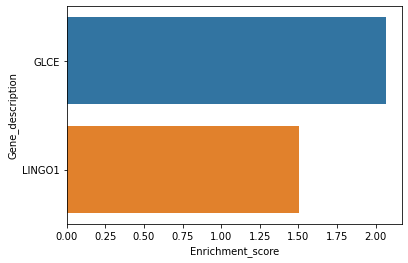

In [6]:
sns.barplot(y='Gene_description',x='Enrichment_score',data=summary_test.head(10),orient='horizontal')

In [56]:
DAVID_func_annot_table


,Category,Term,Count,%,PValue,Genes,List Total,Pop Hits,Pop Total,Fold Enrichment,Bonferroni,Benjamini,FDR
0,GOTERM_BP_DIRECT,GO:0007399~nervous system development,35,6.375228,2.295911e-09,"6595, 8110, 4131, 6310, 9863, 5587, 3084, 351,...",492,364,16852,3.293465,0.000006,0.000006,0.000006
1,GOTERM_BP_DIRECT,GO:0007411~axon guidance,22,4.007286,7.461015e-08,"285220, 9037, 219699, 6586, 10371, 9369, 2044,...",492,181,16852,4.163230,0.000197,0.000099,0.000098
2,GOTERM_CC_DIRECT,GO:0098978~glutamatergic synapse,32,5.828780,1.033824e-07,"9228, 6456, 57460, 23467, 9162, 3084, 2823, 57...",519,367,17917,3.010106,0.000046,0.000046,0.000045
3,GOTERM_CC_DIRECT,GO:0030424~axon,30,5.464481,3.558480e-07,"4131, 10371, 6092, 9162, 3084, 351, 3739, 2048...",519,348,17917,2.976048,0.000159,0.000080,0.000077
4,GOTERM_CC_DIRECT,GO:0005886~plasma membrane,184,33.515483,6.504598e-07,"9228, 9863, 3363, 222256, 3482, 2272, 23327, 3...",519,4618,17917,1.375504,0.000291,0.000097,0.000094
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,GOTERM_CC_DIRECT,GO:0005938~cell cortex,9,1.639344,9.842656e-02,"56288, 3709, 5587, 4642, 9847, 6622, 2917, 587...",519,162,17917,1.917898,1.000000,0.862680,0.833731
180,GOTERM_MF_DIRECT,GO:0046872~metal ion binding,84,15.300546,9.849159e-02,"9586, 128553, 48, 129446, 5587, 160760, 23081,...",498,2534,17390,1.157558,1.000000,1.000000,0.995833
181,GOTERM_BP_DIRECT,GO:0007275~multicellular organism development,11,2.003643,9.935440e-02,"7484, 285220, 2324, 2048, 2651, 1462, 2066, 20...",492,215,16852,1.752430,1.000000,1.000000,0.996212
182,GOTERM_BP_DIRECT,GO:0007507~heart development,11,2.003643,9.935440e-02,"5607, 64220, 2257, 9734, 129446, 5764, 2066, 5...",492,215,16852,1.752430,1.000000,1.000000,0.996212


In [24]:
#manhattan plot:
test = best_SNPs_annot.snp_association.copy()

In [32]:
test['chromosome'] = test['SNP'].apply(lambda x: str.split(x,':')[0])

In [38]:
test_grouped = test.groupby('chromosome')
test.reset_index(inplace=True)

In [41]:
test['minuslog10pval'] = -np.log10(test.P)

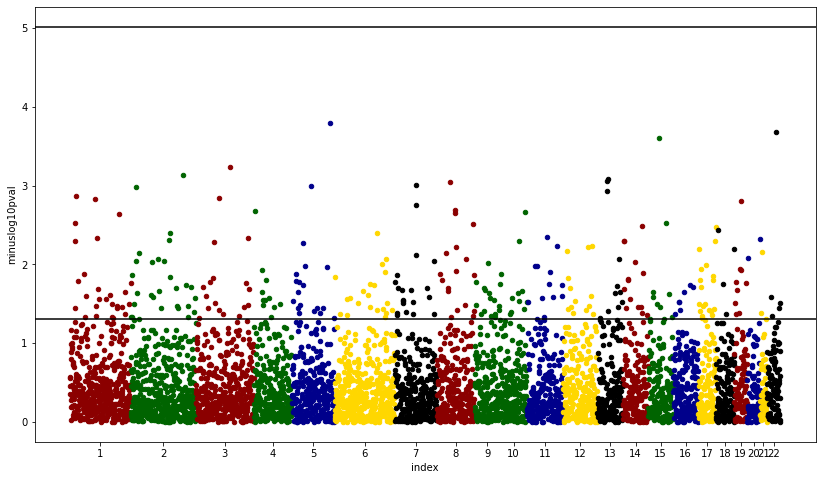

In [80]:
fig = plt.figure(figsize=(14, 8)) # Set the figure size
ax = fig.add_subplot(111)
colors = ['darkred','darkgreen','darkblue','gold','black']
x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(test_grouped):
    group.plot(kind='scatter', x='index', y='minuslog10pval',color=colors[num % len(colors)], ax=ax)
    x_labels.append(name)
    x_labels_pos.append((group['index'].iloc[-1] - (group['index'].iloc[-1] - group['index'].iloc[0])/2))

ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.axhline(-np.log10(0.05),c='black')
ax.axhline(-np.log10(0.05/5183),c='black')
# ax.axhline(-np.log10(0.001),c='black')

## PRSET


In [74]:
model_fit_table = pd.read_csv('./genetic_analysis/Harriet_genetic_file/all_PRS_European/STG_WM/1em3/PRSET/STG_WM.summary',sep='\t')

In [79]:
model_fit_table_new = model_fit_table[model_fit_table['Num_SNP']>=10]

In [77]:
def multiplot_PRSet(model_fit_table,
                   top=10):
    data_full = model_fit_table.copy()
    data_full['neg_log10P'] = -np.log10(data_full['P'])
    top_data_full = data_full.sort_values(by='PRS.R2',ascending=False).head(top).append(data_full[data_full['Set']=='Base'])
    top_data_full.drop_duplicates('Set',inplace=True)
    top_data_full.reset_index(drop=True,inplace=True)
    
    fig, ax = plt.subplots(1, 1)
    sns.set(style='whitegrid', color_codes=True)
    p_values = top_data_full['neg_log10P'].values
    pal = sns.color_palette("coolwarm", len(p_values))
    rank = p_values.argsort().argsort()
    my_cmap = ListedColormap(pal)
    norm = plt.Normalize(p_values.min(), p_values.max())
    sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
    sm.set_array([])
    g = sns.barplot(x='PRS.R2',
                    y='Set',
                    data=top_data_full,
                    palette=np.array(pal)[rank], orient="horizontal",
                    ax=ax)
    cbar = g.figure.colorbar(sm, ax=ax)
    ax.set_title('Barplot of top %d pathways'%top)
    ax.set_ylabel('Set')
    ax.set_xlabel('PRS model fit: R-squared')
    cbar.set_label('-Log 10 P-value')
    

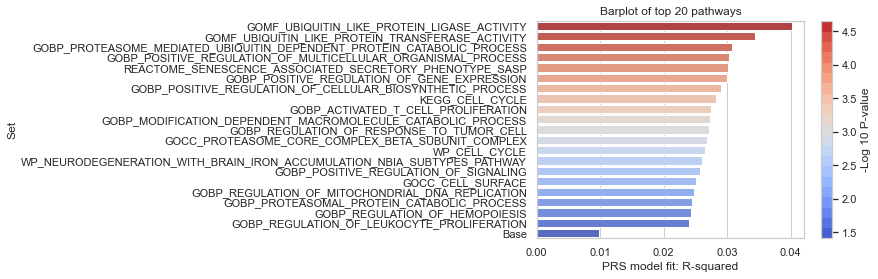

In [80]:
multiplot_PRSet(model_fit_table_new,20)

## FUMA

In [63]:
FUMA_result = f'{preprocessed_dataset_path}/genetic_data/all_PRS_European/Frontal_lobe_WM/5em2/FUMAGENE2FUNC/Frontal_lobe_WM_5em2/FUMA_result'

variable_threshold = '5em2'
variable = 'Frontal_lobe_WM'
SCZ_threshold = '5em2'
file_path_ouput = f'{preprocessed_dataset_path}/genetic_data/all_PRS_European/Frontal_lobe_WM/{SCZ_threshold}/'

In [67]:
glob.glob(f'{FUMA_result}/GS*')

["../../../../OneDrive - King's College London/PhD/schizophrenia_data/preprocessed_dataset/genetic_data/all_PRS_European/Frontal_lobe_WM/5em2/FUMAGENE2FUNC/Frontal_lobe_WM_5em2/FUMA_result\\GS.txt",
 "../../../../OneDrive - King's College London/PhD/schizophrenia_data/preprocessed_dataset/genetic_data/all_PRS_European/Frontal_lobe_WM/5em2/FUMAGENE2FUNC/Frontal_lobe_WM_5em2/FUMA_result\\GS_random.txt"]

In [68]:
import os

In [78]:
# FUMA_res = pd.read_csv(f'{FUMA_result}/GS_random.txt',sep='\t')
FUMA_res = pd.read_csv('GS_random.txt',sep='\t')

best_FUMA_res = FUMA_res[FUMA_res['Category'] == 'MSigDB_custom_entrez'].head(10).reset_index(drop=True).copy()
best_FUMA_res['p'] = best_FUMA_res['p'].astype('float')
best_FUMA_res['N_overlap'] = best_FUMA_res['N_overlap'].astype('int64')
best_FUMA_res['N_genes'] = best_FUMA_res['N_genes'].astype('int64')
best_FUMA_res['adjP'] = best_FUMA_res['p']*19427
best_FUMA_res = best_FUMA_res[best_FUMA_res['adjP']<0.001].copy()
best_FUMA_res['Proportion'] = (best_FUMA_res['N_overlap']/best_FUMA_res['N_genes'])
best_FUMA_res = best_FUMA_res[best_FUMA_res['Proportion']>0.05].copy()

In [6]:
# writer = pd.ExcelWriter('testData.xlsx', engine='xlsxwriter')
# best_FUMA_res.to_excel('best_FUMA_res_random.xlsx',engine='xlsxwriter')

In [7]:
best_FUMA_res = best_FUMA_res.loc[:4,:]

In [81]:
best_FUMA_res.to_excel('random_best.xlsx',index=False)

In [79]:
best_genes_IDs = pd.read_csv(f'{file_path_ouput}FUMAGENE2FUNC/{variable}_{variable_threshold}/best_genes_univar.txt')

best_FUMA_res_dict = {k:v.split(':') for k,v in zip(best_FUMA_res.GeneSet.tolist(),best_FUMA_res.genes.tolist())}

In [27]:
best_genes_IDs

,SNP,A1,BETA,STAT,P_Frontal_lobe_WM,CHR,BP,P_schizo,Base,SNP_ID,Genes_list,N_Genes,Genes_Name,NAME,N_SNP
0,1:12472767,T,-396.492458,-2.285550,0.023385,1,12472767,0.032540,1,1:12472767,[55187],1,VPS13D,VPS13D,1
1,1:17289911,T,378.812113,2.138190,0.033779,1,17289911,0.017860,1,1:17289911,[9696],1,CROCC,CROCC,1
2,1:17395480,G,352.408608,2.206698,0.028533,1,17395480,0.004219,1,1:17395480,[11240],1,PADI2,PADI2,1
3,1:21022092,T,595.281749,2.951223,0.003564,1,21022092,0.026750,1,1:21022092,[57576],1,KIF17,KIF17,2
4,1:21033928,A,912.768096,2.675498,0.008113,1,21033928,0.031200,1,1:21033928,[57576],1,KIF17,KIF17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,22:32339213,T,338.120324,2.128414,0.034591,22,32339213,0.044940,1,22:32339213,[25775],1,C22orf24,C22orf24,1
631,22:32853660,A,463.316682,2.328467,0.020939,22,32853660,0.029030,1,22:32853660,[254240],1,BPIFC,BPIFC,1
632,22:39216667,T,358.212050,2.240548,0.026213,22,39216667,0.000723,1,22:39216667,[23467],1,NPTXR,NPTXR,1
633,22:39883344,C,-481.936218,-2.045633,0.042171,22,39883344,0.001497,1,22:39883344,[4248],1,MGAT3,MGAT3,1


In [28]:
best_genes_IDs[best_genes_IDs['Genes_Name'] == 'DOCK3'] #rs76442143
best_genes_IDs[best_genes_IDs['Genes_Name'] == 'PPARGC1A'] #rs6832165
best_genes_IDs[best_genes_IDs['Genes_Name'] == 'GPM6A'] #rs13142920
best_genes_IDs[best_genes_IDs['Genes_Name'] == 'WSCD2'] #rs10861879
best_genes_IDs[best_genes_IDs['Genes_Name'] == 'PITPNM2'] #rs1984658






,SNP,A1,BETA,STAT,P_Frontal_lobe_WM,CHR,BP,P_schizo,Base,SNP_ID,Genes_list,N_Genes,Genes_Name,NAME,N_SNP


In [18]:
# with open('all_genes.txt', 'w') as f:
#     for gene in all_genes:
#         f.writelines(gene)
#         f.writelines('\n')

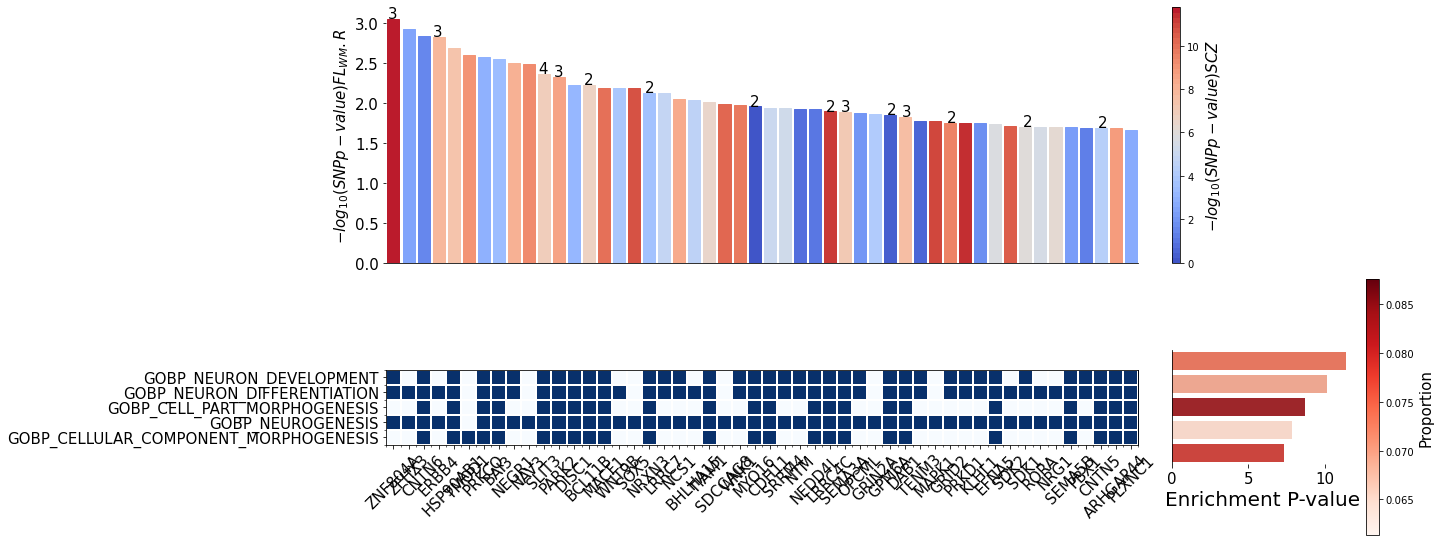

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(20,8))
gs = fig.add_gridspec(2,8)

ax_barplot_top = fig.add_subplot(gs[0,0:6])
ax_heatmap = fig.add_subplot(gs[1,0:6])
ax_enrichment = fig.add_subplot(gs[1,6:8])

heatmap,all_genes,gene_sets = visualisation.Geneset.create_heatmap(best_FUMA_res,
                                                         genes_set_column = 'GeneSet',
                                                         genes_list_column = 'genes',
                                                         gene_table = best_genes_IDs,
                                                         top = 50,
                                                         ordered_by = 'P_Frontal_lobe_WM',
                                                         gene_table_gene_name='Genes_Name'
                                                        )


visualisation.Geneset.visualise_heatmap(heatmap=heatmap,
                                       all_genes=all_genes,
                                       gene_sets=gene_sets,
                                       ax=ax_heatmap)
ax_heatmap.tick_params('y',rotation=0)


cbar_ax = fig.add_subplot(gs[0,6])
divider = make_axes_locatable(cbar_ax)
cax = divider.append_axes('left', size='10%', pad=0.05)


visualisation.Geneset.visualise_gene_p_value(gene_table=best_genes_IDs,
                                            all_genes=all_genes,
                                            gene_table_gene_name='Genes_Name',
                                            ordered_by='P_Frontal_lobe_WM',
                                            coloured_by='P_schizo',
                                            p_threshold=None,
                                            bar_number='N_SNP',
                                             ax=ax_barplot_top,
                                            cbar_ax = cax)
ax_barplot_top.tick_params('y',labelsize=15)
sns.despine(top=True,left=True,right=True,ax=ax_barplot_top)
sns.despine(top=True,left=True,right=True,bottom=True,ax=cbar_ax)
cbar_ax.axis('off')


aspect = 1.5
ax_enrichment.set_aspect(aspect)
visualisation.Geneset.visualise_enrichment_p_value(best_FUMA_res,
                                                   x = 'adjP',
                                                   y='GeneSet',
                                                   xlabel='Enrichment P-value',
                                                   ax=ax_enrichment)
ax_enrichment.tick_params('x',labelsize=15)
ax_enrichment.set_xlabel('Enrichment P-value',fontsize=20)
sns.despine(top=True,bottom=True,right=True,ax=ax_enrichment)
plt.tight_layout()
# fig.savefig(f'{preprocessed_dataset_path}/output_plot/heatmap_with_pval_barplot.pdf')

## MAGMA

In [44]:
MAGMA_res = pd.read_csv('./genetic_analysis/Harriet_genetic_file/all_PRS_European/STG_WM/1em3/MAGMA/STG_WM_summary.gsa.out',skiprows=[0,1,2,3],delim_whitespace=True)

In [50]:
MAGMA_res = MAGMA_res.sort_values(by='P').head(20)

In [52]:
MAGMA_res['FULL_NAME']

,VARIABLE,TYPE,NGENES,BETA,BETA_STD,SE,P,FULL_NAME
5844,GOBP_PRESYNAPTIC_ACTIVE_ZONE...,SET,3,2.80800,0.118550,0.58631,9.123400e-07,GOBP_PRESYNAPTIC_ACTIVE_ZONE_ORGANIZATION
7252,GOMF_STRUCTURAL_CONSTITUENT_...6,SET,2,2.70710,0.093350,0.71959,8.723300e-05,GOMF_STRUCTURAL_CONSTITUENT_OF_PRESYNAPTIC_ACT...
4282,GOBP_MAINTENANCE_OF_PRESYNAP...,SET,2,2.70710,0.093350,0.71959,8.723300e-05,GOBP_MAINTENANCE_OF_PRESYNAPTIC_ACTIVE_ZONE_ST...
4423,GOBP_POSITIVE_REGULATION_OF_...420,SET,7,1.27100,0.081869,0.38540,4.977400e-04,GOBP_POSITIVE_REGULATION_OF_SMALL_GTPASE_MEDIA...
3580,GOBP_REELIN_MEDIATED_SIGNALI...,SET,2,2.32950,0.080327,0.72059,6.252500e-04,GOBP_REELIN_MEDIATED_SIGNALING_PATHWAY
1694,GOBP_ACROSOME_ASSEMBLY,SET,2,2.29450,0.079122,0.72074,7.410500e-04,GOBP_ACROSOME_ASSEMBLY
1968,GOBP_METANEPHROS_MORPHOGENES...,SET,3,1.72310,0.072748,0.58914,1.747600e-03,GOBP_METANEPHROS_MORPHOGENESIS
5068,GOBP_METANEPHRIC_NEPHRON_MOR...,SET,3,1.72310,0.072748,0.58914,1.747600e-03,GOBP_METANEPHRIC_NEPHRON_MORPHOGENESIS
5059,GOBP_RENAL_VESICLE_DEVELOPME...,SET,3,1.72310,0.072748,0.58914,1.747600e-03,GOBP_RENAL_VESICLE_DEVELOPMENT
2914,GOBP_LAYER_FORMATION_IN_CERE...,SET,3,1.72010,0.072622,0.58872,1.764500e-03,GOBP_LAYER_FORMATION_IN_CEREBRAL_CORTEX


In [63]:
def multiplot_MAGMA(model_fit_table,
                   top=10):
    data_full = model_fit_table.copy()
    data_full['neg_log10P'] = -np.log10(data_full['P'])
    top_data_full = data_full.sort_values(by='neg_log10P',ascending=False)
    
    fig, ax = plt.subplots(1, 1)
    sns.set(style='whitegrid', color_codes=True)
    p_values = top_data_full['neg_log10P'].values
    pal = sns.color_palette("coolwarm", len(p_values))
    rank = p_values.argsort().argsort()
    my_cmap = ListedColormap(pal)
    norm = plt.Normalize(p_values.min(), p_values.max())
    sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=norm)
    sm.set_array([])
    g = sns.barplot(x='BETA',
                    y='FULL_NAME',
                    data=top_data_full,
                    palette=np.array(pal)[rank], orient="horizontal",
                    ax=ax)
    cbar = g.figure.colorbar(sm, ax=ax)
    ax.set_title('Barplot of top %d pathways'%top)
    ax.set_ylabel('Set')
    ax.set_xlabel('model fit: BETA')
    cbar.set_label('-Log 10 P-value')
    

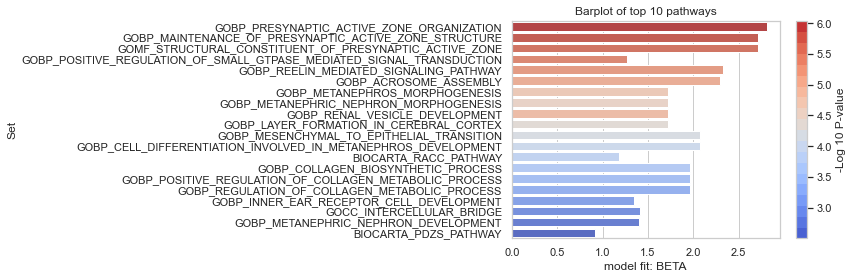

In [64]:

multiplot_MAGMA(MAGMA_res)

## GSEA

In [67]:
GSEA_rnk = pd.read_csv('./genetic_analysis/Harriet_genetic_file/all_PRS_European/STG_WM/1em3/GSEA/STG_summary.genes.rnk',sep='\t')

In [68]:
GSEA_rnk['P'] = -np.log10(GSEA_rnk['P'])

In [69]:
GSEA_rnk.to_csv('./genetic_analysis/Harriet_genetic_file/all_PRS_European/STG_WM/1em3/GSEA/STG_summary.genes.rnk',sep='\t',header=False,index=None)

In [72]:
GSEA_rnk[GSEA_rnk['P']>-np.log10(0.05)]
GSEA_rnk[GSEA_rnk['P']>-np.log10(0.05)].to_csv('./genetic_analysis/Harriet_genetic_file/all_PRS_European/STG_WM/1em3/GSEA/STG_summary_reduced.genes.rnk',sep='\t',header=False,index=None)

In [87]:
GSEA_rnk[GSEA_rnk['P']>-np.log10(0.05)]


,GENE,P
11,54361,1.442661
15,6883,2.519289
18,2035,2.478810
45,7804,1.883957
49,1600,1.333295
...,...,...
1532,5990,1.779604
1533,115704,1.680852
1546,7562,1.386729
1650,150290,1.583077


## Get random result